In [71]:
import csv
import pandas as pd
import numpy as np
import os
import datetime
from datetime import date
import dateutil
from time import gmtime, strftime
import time
import math
pd.set_option('display.max_columns', 100)
pd.options.display.max_colwidth = 100
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from pandas import read_csv, datetime, DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.2f}'.format
import itertools

<ipython-input-71-26d390f30268>:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import read_csv, datetime, DataFrame


In [2]:
f = pd.read_csv("movie_metadata.txt")

In [3]:
# Deselecting columns that are neutral and donot contribute to the model building
df = f[f.columns.difference(['director_name', 'actor_2_name','genres','actor_1_name','movie_title','actor_3_name',\
                             'plot_keywords','movie_imdb_link','title_year','language','country'])]

# Removing rows with null values of 1/3rd or more than the number of columns 
master = df[df.isnull().sum(axis=1) < 5].reset_index(drop = True)

In [4]:
# Fill Null values with median value for the numerical attributes and mode for the categorical attribiutes
master = master.fillna(master.median())
master = master.fillna(master.mode().iloc[0])
train_data = master

### Data Exploration

In [87]:
master['imdb_buc'] = pd.cut(master['imdb_score'], bins=[0,5,6,7,8,9,10],
    labels=['[0,5]','[5-6]','[6-7]','[7-8]','[8-9]','[9-10]'])

master['content_rating'].value_counts()

R            2375
PG-13        1460
PG            701
Not Rated     116
G             112
Unrated        62
Approved       55
TV-14          29
TV-MA          20
TV-PG          13
X              13
TV-G           10
Passed          9
NC-17           7
GP              6
M               5
TV-Y            1
TV-Y7           1
Name: content_rating, dtype: int64

##### R and PG-13 rated movies are the highest of all ratings. we'll look at the imdb score buckets with these two.

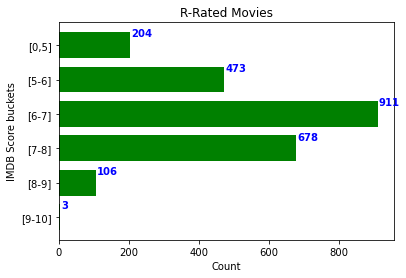

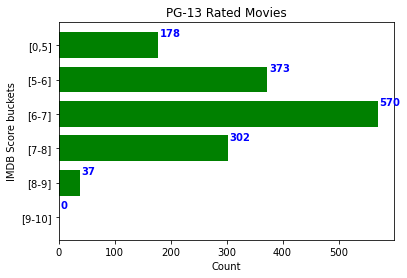

In [92]:
cr = master.groupby(['content_rating','imdb_buc'])['imdb_score'].count().reset_index().sort_values('imdb_buc', ascending = False)
rcr = cr[cr['content_rating'] == 'R']
pg13cr = cr[cr['content_rating'] == 'PG-13']

def plots(df,column,titlee, clr = 'green'):
    fig, ax = plt.subplots()
    ax.barh(df[column], df['imdb_score'], 0.75, color = clr)
    for i, v in enumerate(df['imdb_score']):
        ax.text(v + 3, i + .25, str(v), 
                color = 'blue', fontweight = 'bold')
    plt.title(titlee)
    plt.xlabel('Count')
    plt.ylabel('IMDB Score buckets') 
    plt.show()

plots(rcr,'imdb_buc','R-Rated Movies')
plots(pg13cr,'imdb_buc','PG-13 Rated Movies')

Text(0.5, 1.0, 'Scatter plot on number of users vs imdb score')

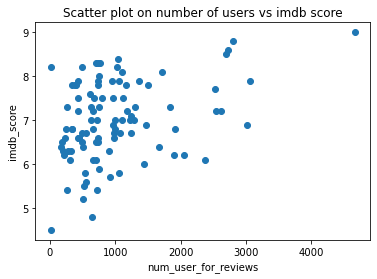

In [96]:
# num_user_for_reviews has been the most correlated attribute for the imdb score
plt.scatter(master['num_user_for_reviews'][:100],master['imdb_score'][:100])
plt.xlabel('num_user_for_reviews')
plt.ylabel('imdb_score')
plt.title('Scatter plot on number of users vs imdb score')

### Encoding and Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce

In [7]:
# Converting the categorical variables to numerical using target encoding
tenc=ce.TargetEncoder() 
df_tenc = tenc.fit_transform(train_data[['color','content_rating']],train_data['imdb_score'])
train_data = df_tenc.join(train_data.drop(['color','content_rating'],axis = 1))

In [8]:
corr = []
for col in train_data.columns:
    corr.append([col,train_data[col].corr(train_data['imdb_score'])])

# dropping attributes with correlation less than 0.1 
corr = pd.DataFrame(corr, columns = ['Attribute', 'correlation with IMDB Score'])
selected = corr[corr['correlation with IMDB Score'] > 0.09].sort_values('correlation with IMDB Score', ascending = False).reset_index(drop=True)[1:]
selected

,Attribute,correlation with IMDB Score
1,num_voted_users,0.42
2,num_critic_for_reviews,0.31
3,num_user_for_reviews,0.29
4,duration,0.27
5,movie_facebook_likes,0.25
6,content_rating,0.20
7,gross,0.18
8,director_facebook_likes,0.16
9,color,0.15


In [ ]:
TargetVariable=['imdb_score']
Predictors=list(selected['Attribute'])
 
X=train_data[Predictors].values
y=train_data[TargetVariable].values

In [10]:
# Sandardization of data
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y) 

split into train test sets

In [11]:
# split into train test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Train

#### Random forest Regressor 

In [21]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
# create regressor object
regressor = RandomForestRegressor(n_estimators = 500, random_state = 42)
 
# fit the regressor with x and y data
regressor.fit(X_train, y_train)

<ipython-input-21-bc77971a91db>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=500, random_state=42)

In [22]:
# Generating Predictions on testing data
Predictions=regressor.predict(X_test)
 
# Scaling the predicted data back to original scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Scaling the y_test data back to original scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print("Mean Absolute Error",mean_absolute_error(y_test_orig,Predictions))
print("Mean Squared Error",mean_squared_error(y_test_orig,Predictions))

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['imdb_score']=y_test_orig

TestingData['RF_Predicted_imdb_score']=Predictions

APE=100*(abs(TestingData['imdb_score']-TestingData['RF_Predicted_imdb_score'])/TestingData['imdb_score'])
TestingData['APE']=APE
 
print('The Accuracy of Random forest model is:', 100-np.mean(APE))

Mean Absolute Error 0.5912926926926925
Mean Squared Error 0.6377249292092091
The Accuracy of Random forest model is: 89.30878674579675


In [44]:
# Feature Importances
pd.DataFrame({'attribute':Predictors,'importance':regressor.feature_importances_}).sort_values('importance',ascending = False)

,attribute,importance
0,num_voted_users,0.30
3,duration,0.16
6,gross,0.12
2,num_user_for_reviews,0.11
1,num_critic_for_reviews,0.10
4,movie_facebook_likes,0.07
7,director_facebook_likes,0.07
5,content_rating,0.06
8,color,0.01


#### Support Vector Regression

In [29]:
from sklearn.svm import SVR, LinearSVR
reg = SVR(kernel="rbf")
reg.fit(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR()

In [34]:
# Generating Predictions on testing data
Preds=reg.predict(X_test)
 
# Scaling the predicted data back to original scale
Preds=TargetVarScalerFit.inverse_transform(Preds)
 
# Scaling the y_test data back to original scale
y_test_org=TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Dat=PredictorScalerFit.inverse_transform(X_test)

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print("MAE",mean_absolute_error(y_test_org,Preds))
print("MSE",mean_squared_error(y_test_org,Preds))

TestingData['SVR_Predicted_imdb_score']=Preds

APE_SVR=100*(abs(TestingData['imdb_score']-TestingData['SVR_Predicted_imdb_score'])/TestingData['imdb_score'])
TestingData['APE_SVR']=APE_SVR
 
print('The Accuracy of Support vector model is:', 100-np.mean(APE_SVR))

MAE 0.6404560774193948
MSE 0.7519709998091028


#### Neural network regression

In [12]:
from keras.models import Sequential
from keras.layers import Dense

# Defining a function to find the best parameters for ANN
def BestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[10, 15, 20]
    epoch_list  =   [5, 10, 50]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
            model.add(Dense(1, kernel_initializer='normal'))
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
            
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)


ResultsData=BestParams(X_train, y_train, X_test, y_test)

1 Parameters: batch_size: 10 - epochs: 5 Accuracy: 91.54508249580793
2 Parameters: batch_size: 10 - epochs: 10 Accuracy: 91.97791016862234
3 Parameters: batch_size: 10 - epochs: 50 Accuracy: 90.74944847579904
4 Parameters: batch_size: 15 - epochs: 5 Accuracy: 96.15731356474272
5 Parameters: batch_size: 15 - epochs: 10 Accuracy: 95.19634946002719
6 Parameters: batch_size: 15 - epochs: 50 Accuracy: 99.00397227149413
7 Parameters: batch_size: 20 - epochs: 5 Accuracy: 95.19757218123436
8 Parameters: batch_size: 20 - epochs: 10 Accuracy: 94.48549857480869
9 Parameters: batch_size: 20 - epochs: 50 Accuracy: 96.36282148119358


###### Fitting the ANN to the Training set with the best parameteres obtained from the above

In [13]:
model = Sequential()
model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train ,batch_size = 15 , epochs = 50, verbose=1)

Epoch 1/50
267/267 [==============================] - 1s 2ms/step - loss: 0.9098
Epoch 2/50
267/267 [==============================] - 0s 1ms/step - loss: 0.7176
Epoch 3/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6843
Epoch 4/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6729
Epoch 5/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6647
Epoch 6/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6588
Epoch 7/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6527
Epoch 8/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6482
Epoch 9/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6440
Epoch 10/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6402
Epoch 11/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6377
Epoch 12/50
267/267 [==============================] - 0s 1ms/step - loss: 0.6348
Epoch 13/50
267/267 [====

In [14]:
# Generating Predictions on testing data
Pred=model.predict(X_test)
 
# Scaling the predicted data back to original scale
Pred=TargetVarScalerFit.inverse_transform(Pred)
 
# Scaling the y_test data back to original scale
y_test_og=TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
TestData=PredictorScalerFit.inverse_transform(X_test)

In [45]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(y_test_og,Pred))
print("MAE",mean_absolute_error(y_test_og,Pred))

TestingData['ANN_Predicted_imdb_score']=Pred
APE_ANN=100*(abs(TestingData['imdb_score']-TestingData['ANN_Predicted_imdb_score'])/TestingData['imdb_score'])
TestingData['APE_ANN']=APE_ANN
 
print('The Accuracy of Artificial Neural network model is:', 100-np.mean(APE_ANN))

MSE 0.7348626777437048
MAE 0.6414210829290901
The Accuracy of Artificial Neural network model is: 88.3897273713733


## Conclusion

#### Looking at the predictions, all the three models have performed considerably equal with an average accuracy of ~0.88 and MAE of 0.60. 

#### The number of parameters in the Artificial neural networks that need be trained are too huge and is higher compared to the other two algorithms. Same is case with Support vector regression where in the number of parameters and training time is considerably less compared to random forest regression. 

#### Hence in any case if the performance of multiple algorithms on a dataset are close to each other then model which would make more sense in this case would be the simplistic one. According to occams razor, simpler the model the better it is. 

#### "Hence Random forest regressor would be ideal for deployment in this case." 